### imports:

In [2]:
import os
import torchaudio
from torch.utils.data import Dataset
import random
import torch
import torchaudio.transforms as T
import noisereduce as nr
from tqdm import tqdm
import numpy as np
import scipy.signal
import librosa
import matplotlib.pyplot as plt

### DATASET CLASS:

In [3]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, task="gender", transform=None, feature_extractor=None, n_persons=None, seed=42, 
                 use_preprocessed=False, preprocessed_dir="preprocessed",
                 features_to_extract=None, segment_length=None, segment_overlap=None, **feature_params):
        """
        Args:
            root_dir (str): Path to the directory containing the audio files.
            task (str): The task to perform. Options are "gender" or "owner".
            transform (callable, optional): Optional transform to be applied on a sample.
            feature_extractor (callable, optional): Function to extract features from the waveform.
            n_persons (int, optional): Number of unique persons (studentIDs) to include for owner classification.
            seed (int, optional): Seed for reproducibility when selecting N persons.
            use_preprocessed (bool, optional): Whether to use preprocessed data if available.
            preprocessed_dir (str, optional): Directory containing preprocessed features.
        """
        self.root_dir = root_dir
        self.task = task
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.n_persons = n_persons
        self.seed = seed
        self.use_preprocessed = use_preprocessed
        self.preprocessed_dir = preprocessed_dir
        self.features_to_extract = features_to_extract or []
        self.segment_length = segment_length
        self.segment_overlap = segment_overlap
        self.feature_params = feature_params

        self.data = []
        self.student_ids = set()

        # Load and parse filenames
        for file in os.listdir(root_dir):
            if file.endswith(".mp3"):
                parts = file[:-4].split("_")  # Remove .mp3 and split by _

                # Validate file naming format
                if len(parts) == 4 and parts[0].startswith("HW") and \
                   (parts[1] == "intro" or parts[1].startswith("Q")) and \
                   parts[3] in ["male", "female"]:

                    try:
                        homework_number = int(parts[0][2:])
                        question_number = None if parts[1] == "intro" else int(parts[1][1:])
                        student_id = parts[2]
                        gender = parts[3]

                        self.data.append({
                            "file_path": os.path.join(root_dir, file),
                            "homework_number": homework_number,
                            "question_number": question_number,
                            "student_id": student_id,
                            "gender": gender
                        })

                        self.student_ids.add(student_id)
                    except ValueError:
                        # Skip files with invalid formats
                        continue

        if task == "owner" and n_persons is not None:
            random.seed(seed)
            selected_ids = random.sample(self.student_ids, n_persons)
            self.data = [item for item in self.data if item["student_id"] in selected_ids]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.use_preprocessed and self.preprocessed_dir:
            preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
            if os.path.exists(preprocessed_path):
                return torchaudio.load(preprocessed_path)

        file_path = sample["file_path"]

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)

        # Resample to a consistent rate
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            sample_rate = target_sample_rate

        # Apply noise reduction
        waveform = nr.reduce_noise(y=waveform.numpy(), sr=sample_rate)
        waveform = torch.tensor(waveform)

        # Normalize waveform
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)

        # Apply transform if specified
        if self.transform:
            waveform = self.transform(waveform)

        # Extract features if feature_extractor is specified
        if self.feature_extractor:
            features = self.feature_extractor(waveform, sample_rate)
        else:
            features = waveform

        if self.task == "gender":
            label = 0 if sample["gender"] == "male" else 1
        elif self.task == "owner":
            label = sample["student_id"]
        else:
            raise ValueError("Unsupported task. Use 'gender' or 'owner'.")

        return {
            "features": features,
            "sample_rate": sample_rate,
            "label": label,
            "metadata": sample
        }
    
    def wiener_filter(self, noisy_signal, sr, mysize=29, noise_std=0.5):
        return scipy.signal.wiener(noisy_signal, mysize=mysize, noise=noise_std)

    def preprocess_and_save(self):
        """
        Preprocess and save features to disk as MP3 files to avoid reloading and reprocessing large datasets.
        """
        os.makedirs(self.preprocessed_dir, exist_ok=True)
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)

            # Resample to a consistent rate
            target_sample_rate = 44100
            if sample_rate != target_sample_rate:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
                waveform = resampler(waveform)
                sample_rate = target_sample_rate

            # # Apply noise reduction

            # # Normalize waveform
            waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)
            
            waveform = self.wiener_filter(noisy_signal=waveform.numpy(), sr=target_sample_rate)
            waveform = torch.tensor(waveform)
            # Convert to Pydub AudioSegment for MP3 saving

            # Save preprocessed audio as MP3
            save_path = os.path.join(self.preprocessed_dir, os.path.basename(file_path))
            torchaudio.save(save_path, waveform, target_sample_rate)
            
    def plot_audio_lengths(self):
        lengths = []
        for sample in tqdm(self.data, desc="Processing Audio Files"):
            file_path = sample["file_path"]
            waveform, sample_rate = torchaudio.load(file_path)
            length = waveform.size(1) / sample_rate
            lengths.append(length)

        plt.figure(figsize=(18, 9))
        plt.hist(lengths, bins=100, edgecolor='black')
        plt.xlabel('Length (seconds)')
        plt.ylabel('Number of Files')
        plt.title('Histogram of Audio File Lengths')
        plt.show()
        
        min_length = min(lengths)
        print(f"Minimum audio length: {min_length:.2f} seconds")
        



In [54]:
import os
import random
import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import noisereduce as nr
import scipy.signal
import torch.nn.functional as F  # for padding


class AudioDataset(Dataset):
    def __init__(self, 
                 root_dir, 
                 task="gender", 
                 transform=None, 
                 feature_extractor=None, 
                 n_persons=None, 
                 seed=42, 
                 use_preprocessed=False, 
                 preprocessed_dir="preprocessed",
                 # Segmentation parameters:
                 segment_duration=2.0,   # in seconds for each segment
                 segment_overlap=0.5,    # in seconds, overlap between segments
                 feature_list=None,      # list of features to extract
                 save_features_dir=None, # directory where extracted features & segments are saved
                 use_extracted_features=False  # if True, load from extracted features instead of raw audio
                ):
        """
        Args:
            root_dir (str): Directory containing the original audio files.
            task (str): "gender" or "owner" classification.
            transform (callable, optional): Additional transform to apply.
            feature_extractor (callable, optional): Custom feature extraction function.
            n_persons (int, optional): For owner classification, the number of unique persons.
            seed (int): Random seed.
            use_preprocessed (bool): If True, use preprocessed audio files.
            preprocessed_dir (str): Directory for preprocessed audio.
            segment_duration (float): Duration (in seconds) for each segment.
            segment_overlap (float): Overlap (in seconds) between consecutive segments.
            feature_list (list, optional): List of features to extract. Options include:
                'mfcc', 'fft', 'logmel', 'spectral_centroid', 'chroma', 
                'spectral_contrast', 'zero_crossing_rate', 'lpc', 'plp', 'energy'.
                If None, a default set (excluding 'plp') is used.
            save_features_dir (str, optional): Directory where extracted segments and their features are saved.
            use_extracted_features (bool): If True, use the already extracted segmented features stored
                in `save_features_dir`. In this case files are expected to be named as:
                  - Features: {original_filename}_p{i}_features.npz  
                  - Audio:    {original_filename}_p{i}.wav
        """
        self.task = task
        self.transform = transform
        self.feature_extractor = feature_extractor  # if provided, bypasses the built-in extractor
        self.n_persons = n_persons
        self.seed = seed
        self.use_preprocessed = use_preprocessed
        self.preprocessed_dir = preprocessed_dir

        # Segmentation parameters:
        self.segment_duration = segment_duration
        self.segment_overlap = segment_overlap
        
        if feature_list is None:
            # Default feature list does not include PLP here unless you add it.
            self.feature_list = ['mfcc', 'fft', 'logmel', 'spectral_centroid', 
                                 'chroma', 'spectral_contrast', 'zero_crossing_rate', 
                                 'lpc', 'plp', 'energy']
        else:
            self.feature_list = feature_list

        self.save_features_dir = save_features_dir
        self.use_extracted_features = use_extracted_features

        self.data = []
        self.student_ids = set()

        # Two modes for populating self.data:
        if self.use_extracted_features:
            if self.save_features_dir is None:
                raise ValueError("save_features_dir must be provided when using extracted features.")
            # Scan the save_features_dir; expected structure:
            #   save_features_dir/{original_filename}/ with files:
            #       {original_filename}_p{i}_features.npz and {original_filename}_p{i}.wav
            for subdir in os.listdir(self.save_features_dir):
                subdir_path = os.path.join(self.save_features_dir, subdir)
                if os.path.isdir(subdir_path):
                    # subdir should be the base filename (e.g., "HW5_intro_123456_male")
                    for file in os.listdir(subdir_path):
                        if file.endswith("_features.npz"):
                            full_feat_path = os.path.join(subdir_path, file)
                            # Expected file name pattern: {base_filename}_p{i}_features.npz
                            name = file[:-len("_features.npz")]  # remove suffix
                            parts = name.split("_p")
                            if len(parts) != 2:
                                continue
                            base_filename, part_str = parts
                            try:
                                part_num = int(part_str)
                            except ValueError:
                                continue
                            base_parts = base_filename.split("_")
                            if len(base_parts) != 4:
                                continue
                            try:
                                homework_number = int(base_parts[0][2:])
                            except ValueError:
                                homework_number = None
                            question_number = None
                            if base_parts[1] != "intro" and base_parts[1].startswith("Q"):
                                try:
                                    question_number = int(base_parts[1][1:])
                                except ValueError:
                                    question_number = None
                            student_id = base_parts[2]
                            gender = base_parts[3]
                            self.student_ids.add(student_id)
                            audio_filename = f"{base_filename}_p{part_str}.wav"
                            audio_file = os.path.join(subdir_path, audio_filename)
                            
                            self.data.append({
                                "features_file": full_feat_path,
                                "audio_file": audio_file,
                                "homework_number": homework_number,
                                "question_number": question_number,
                                "student_id": student_id,
                                "gender": gender,
                                "part": part_num,
                                "base_filename": base_filename
                            })
            self.data.sort(key=lambda x: (x["base_filename"], x["part"]))
        else:
            # Use original files (assumed to be .mp3) from root_dir.
            for file in os.listdir(root_dir):
                if file.endswith(".mp3"):
                    parts = file[:-4].split("_")
                    if len(parts) == 4 and parts[0].startswith("HW") and \
                       (parts[1] == "intro" or parts[1].startswith("Q")) and \
                       parts[3] in ["male", "female"]:
                        try:
                            homework_number = int(parts[0][2:])
                            question_number = None if parts[1] == "intro" else int(parts[1][1:])
                            student_id = parts[2]
                            gender = parts[3]
                            self.data.append({
                                "file_path": os.path.join(root_dir, file),
                                "homework_number": homework_number,
                                "question_number": question_number,
                                "student_id": student_id,
                                "gender": gender,
                                "base_filename": file[:-4]
                            })
                            self.student_ids.add(student_id)
                        except ValueError:
                            continue

            if task == "owner" and n_persons is not None:
                random.seed(seed)
                selected_ids = random.sample(list(self.student_ids), n_persons)
                self.data = [item for item in self.data if item["student_id"] in selected_ids]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.use_extracted_features:
            sample = self.data[idx]
            # Load compressed extracted features.
            feat_npz = np.load(sample["features_file"])
            features = {key: feat_npz[key] for key in feat_npz.files}
            waveform, sample_rate = torchaudio.load(sample["audio_file"])
            if self.task == "gender":
                label = 0 if sample["gender"] == "male" else 1
            elif self.task == "owner":
                label = sample["student_id"]
            else:
                raise ValueError("Unsupported task. Use 'gender' or 'owner'.")
            return {
                "features": features,
                "sample_rate": sample_rate,
                "label": label,
                "metadata": sample
            }
        else:
            sample = self.data[idx]
            if self.use_preprocessed and self.preprocessed_dir:
                preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
                if os.path.exists(preprocessed_path):
                    waveform, sample_rate = torchaudio.load(preprocessed_path)
                else:
                    waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            else:
                waveform, sample_rate = self._load_and_preprocess(sample["file_path"])

            if self.transform:
                waveform = self.transform(waveform)

            if self.feature_extractor:
                features = self.feature_extractor(waveform, sample_rate)
            else:
                features = self._extract_features(waveform, sample_rate)

            if self.save_features_dir is not None:
                self._save_extracted(sample, waveform, features, sample_rate, save_audio=False)

            if self.task == "gender":
                label = 0 if sample["gender"] == "male" else 1
            elif self.task == "owner":
                label = sample["student_id"]
            else:
                raise ValueError("Unsupported task. Use 'gender' or 'owner'.")
            return {
                "features": features,
                "sample_rate": sample_rate,
                "label": label,
                "metadata": sample
            }

    def _load_and_preprocess(self, file_path):
        """Load an audio file, resample to 16kHz, perform noise reduction, and normalize."""
        waveform, sample_rate = torchaudio.load(file_path)
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)
            sample_rate = target_sample_rate

        waveform_np = waveform.numpy()
        waveform_np = nr.reduce_noise(y=waveform_np, sr=sample_rate)
        waveform = torch.tensor(waveform_np)
        waveform = (waveform - waveform.mean()) / (waveform.std() + 1e-7)
        return waveform, sample_rate

    def _extract_features(self, waveform, sample_rate):
        """
        Splits the waveform into overlapping segments and extracts features for each segment.
        Returns a list of dictionaries (one per segment).
        """
        seg_samples = int(self.segment_duration * sample_rate)
        overlap_samples = int(self.segment_overlap * sample_rate)
        hop_samples = seg_samples - overlap_samples

        signal = waveform[0] if waveform.ndim > 1 else waveform
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
        total_samples = signal.shape[0]

        segments_features = []
        for start in range(0, total_samples - seg_samples + 1, hop_samples):
            end = start + seg_samples
            segment = signal[start:end]
            seg_feat = self._extract_features_from_segment(segment, sample_rate)
            segments_features.append({
                "segment_features": seg_feat,
                "segment_audio": segment,
                "start_sample": start,
                "end_sample": end
            })
        return segments_features

    def _extract_features_from_segment(self, signal, sample_rate):
        """
        Given a 1D numpy array (or tensor converted to numpy) representing a segment, 
        extract the selected features.
        Returns a dictionary of features.
        """
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()
            
        features = {}
        if 'mfcc' in self.feature_list:
            features['mfcc'] = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
        if 'fft' in self.feature_list:
            fft = librosa.stft(signal, n_fft=2048)
            features['fft'] = np.abs(fft)
        if 'logmel' in self.feature_list:
            S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
            features['logmel'] = librosa.power_to_db(S, ref=np.max)
        if 'spectral_centroid' in self.feature_list:
            features['spectral_centroid'] = librosa.feature.spectral_centroid(y=signal, sr=sample_rate)
        if 'chroma' in self.feature_list:
            features['chroma'] = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
        if 'spectral_contrast' in self.feature_list:
            features['spectral_contrast'] = librosa.feature.spectral_contrast(y=signal, sr=sample_rate)
        if 'zero_crossing_rate' in self.feature_list:
            features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y=signal)
        if 'lpc' in self.feature_list:
            try:
                features['lpc'] = librosa.lpc(signal, order=16)
            except Exception:
                features['lpc'] = None
        # if 'plp' in self.feature_list:
        #     features['plp'] = self._compute_plp(signal, sample_rate)
        if 'energy' in self.feature_list:
            features['energy'] = librosa.feature.rms(y=signal)
        return features

    def _compute_plp(self, signal, sr):
        """
        A simplified implementation of Perceptual Linear Prediction (PLP).
        Steps:
          1. Compute a short-time power spectrum (using an STFT).
          2. Average the power spectrum over time.
          3. Map the average power spectrum onto the Bark scale using a triangular filter bank.
          4. Apply an approximate equal-loudness pre-emphasis.
          5. Apply cube-root compression.
          6. Fit an all-pole model (LPC) to the compressed spectral envelope.
        """
        n_fft = 512
        hop_length = int(0.010 * sr)  # 10ms hop
        win_length = int(0.025 * sr)  # 25ms window
        S = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hamming'))**2
        power_spectrum = np.mean(S, axis=1)
        freqs = np.linspace(0, sr/2, len(power_spectrum))
        bark = 13 * np.arctan(0.00076 * freqs) + 3.5 * np.arctan((freqs / 7500.0)**2)
        
        n_bark = 20
        bark_min, bark_max = bark[0], bark[-1]
        bark_bins = np.linspace(bark_min, bark_max, n_bark+2)
        filter_bank = np.zeros((n_bark, len(freqs)))
        for i in range(1, n_bark+1):
            left = bark_bins[i-1]
            center = bark_bins[i]
            right = bark_bins[i+1]
            for j, b in enumerate(bark):
                if b < left:
                    filter_bank[i-1, j] = 0
                elif left <= b <= center:
                    filter_bank[i-1, j] = (b - left) / (center - left)
                elif center < b <= right:
                    filter_bank[i-1, j] = (right - b) / (right - center)
                else:
                    filter_bank[i-1, j] = 0
        E = np.dot(filter_bank, power_spectrum)
        
        filter_centers = []
        for i in range(n_bark):
            weights = filter_bank[i]
            if weights.sum() > 0:
                center_freq = np.sum(freqs * weights) / np.sum(weights)
            else:
                center_freq = 0
            filter_centers.append(center_freq)
        filter_centers = np.array(filter_centers)
        
        eq_weight = ((filter_centers**2 + 56.8e6) / (filter_centers**2 + 6.3e6))**0.24
        E_eq = E * eq_weight
        E_compressed = E_eq ** (1/3.0)
        
        try:
            plp_coeffs = librosa.lpc(E_compressed, order=16)
        except Exception:
            plp_coeffs = None
        
        return plp_coeffs

    def _save_extracted(self, sample, waveform, segments_features, sample_rate, save_audio=True):
        """
        Save each segment’s audio and features to the save_features_dir.
        Files are named as:
          - Audio:    {base_filename}_p{segment_index}.wav  (if save_audio is True)
          - Features: {base_filename}_p{segment_index}_features.npz
        They are stored in a folder named after the base filename.
        """
        base_filename = sample["base_filename"]
        file_save_dir = os.path.join(self.save_features_dir, base_filename)
        os.makedirs(file_save_dir, exist_ok=True)
        for i, seg in enumerate(segments_features):
            seg_audio = seg["segment_audio"]
            seg_feat = seg["segment_features"]
            if save_audio:
                audio_save_path = os.path.join(file_save_dir, f"{base_filename}_p{i}.wav")
                torchaudio.save(audio_save_path, torch.tensor(seg_audio).unsqueeze(0), sample_rate)
            feat_save_path = os.path.join(file_save_dir, f"{base_filename}_p{i}_features.npz")
            np.savez_compressed(feat_save_path, **seg_feat)

    def plot_first_five_all_features(self):
        """
        Plots all extracted features for the first five samples.
        For each sample, iterates over each feature. If the feature is 2D, a heatmap is plotted;
        if it is 1D, a line plot is drawn.
        """
        num_samples = min(5, len(self))
        for idx in range(num_samples):
            sample = self.__getitem__(idx)
            if self.use_extracted_features:
                feat_dict = sample["features"]
            else:
                segments = sample["features"]
                if not segments:
                    continue
                feat_dict = segments[0]["segment_features"]
            feature_keys = list(feat_dict.keys())
            num_features = len(feature_keys)
            plt.figure(figsize=(5, 4*num_features))
            plt.suptitle(f"Sample {idx} Features", fontsize=16)
            for i, key in enumerate(feature_keys):
                plt.subplot(num_features, 1, i + 1)
                feat = feat_dict[key]
                if feat is None:
                    plt.title(f"{key}\n(None)")
                    continue
                if feat.ndim == 2:
                    plt.imshow(feat, aspect='auto', origin='lower', cmap='viridis')
                    plt.title(key)
                    plt.xlabel("Time Frames")
                    plt.ylabel(key.upper())
                elif feat.ndim == 1:
                    plt.plot(feat)
                    plt.title(key)
                    plt.xlabel("Index")
                    plt.ylabel("Value")
                else:
                    plt.text(0.5, 0.5, "Unknown dims", horizontalalignment='center')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    def extract_and_save_all_features(self):
        """
        Loops over the dataset (using preprocessed audio if available)
        and extracts and saves all features for every sample.
        """
        if self.use_extracted_features:
            print("Dataset is already in extracted-features mode.")
            return

        print("Extracting and saving features for all samples...")
        for idx in tqdm(range(len(self))):
            sample = self.data[idx]
            if self.use_preprocessed and self.preprocessed_dir:
                preprocessed_path = os.path.join(self.preprocessed_dir, os.path.basename(sample["file_path"]))
                if os.path.exists(preprocessed_path):
                    waveform, sample_rate = torchaudio.load(preprocessed_path)
                else:
                    waveform, sample_rate = self._load_and_preprocess(sample["file_path"])
            else:
                waveform, sample_rate = self._load_and_preprocess(sample["file_path"])

            if self.transform:
                waveform = self.transform(waveform)

            if self.feature_extractor:
                features = self.feature_extractor(waveform, sample_rate)
            else:
                features = self._extract_features(waveform, sample_rate)

            if self.save_features_dir is not None:
                # Optionally, set save_audio=False to only save features.
                self._save_extracted(sample, waveform, features, sample_rate, save_audio=False)
        print("Feature extraction and saving complete.")




In [55]:
myData = AudioDataset("../../HW1_M", preprocessed_dir="../../preprocessed", segment_duration=2.0, segment_overlap=0.5, 
                      use_preprocessed=True, save_features_dir="../../features")

In [56]:
sample = myData[0]
print("Sample Metadata (Original):", sample["metadata"])
if isinstance(sample["features"], list):
    print("Number of segments extracted:", len(sample["features"]))

Sample Metadata (Original): {'file_path': '../../HW1_M\\HW1_intro_151501033_male.mp3', 'homework_number': 1, 'question_number': None, 'student_id': '151501033', 'gender': 'male', 'base_filename': 'HW1_intro_151501033_male'}
Number of segments extracted: 9


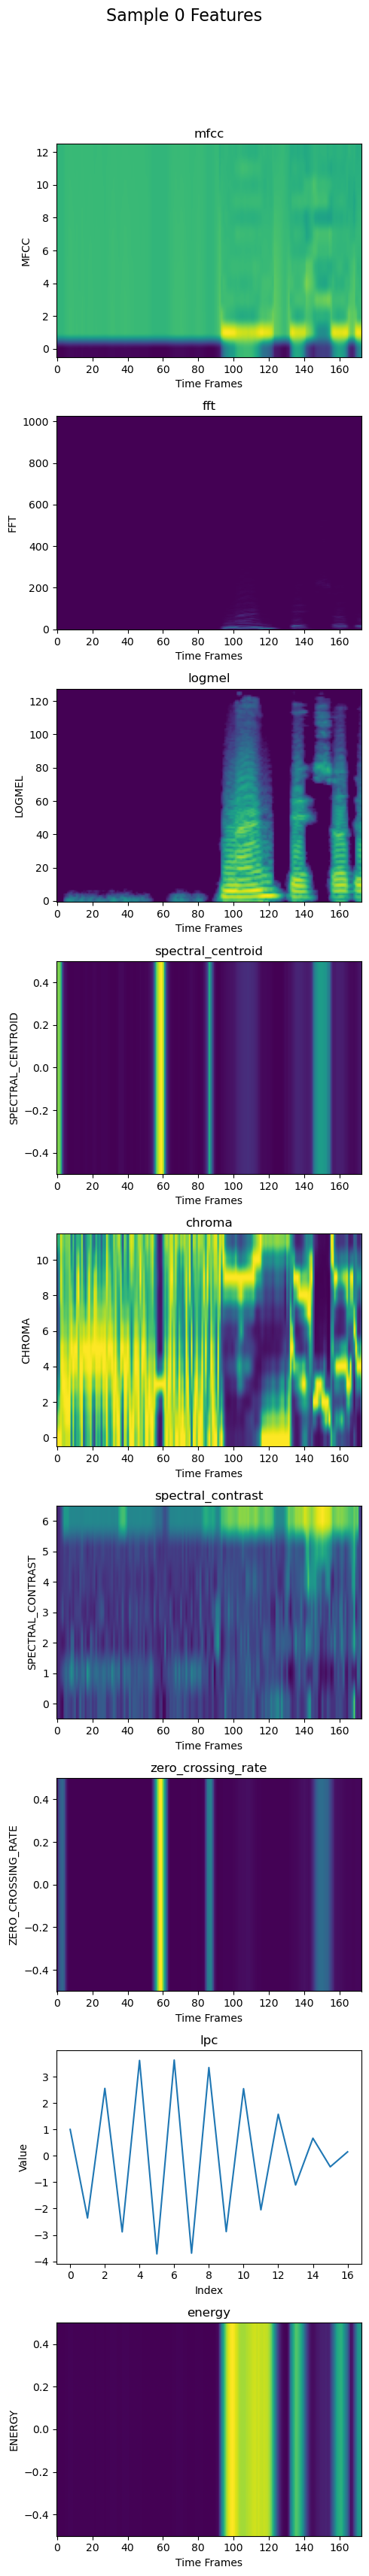

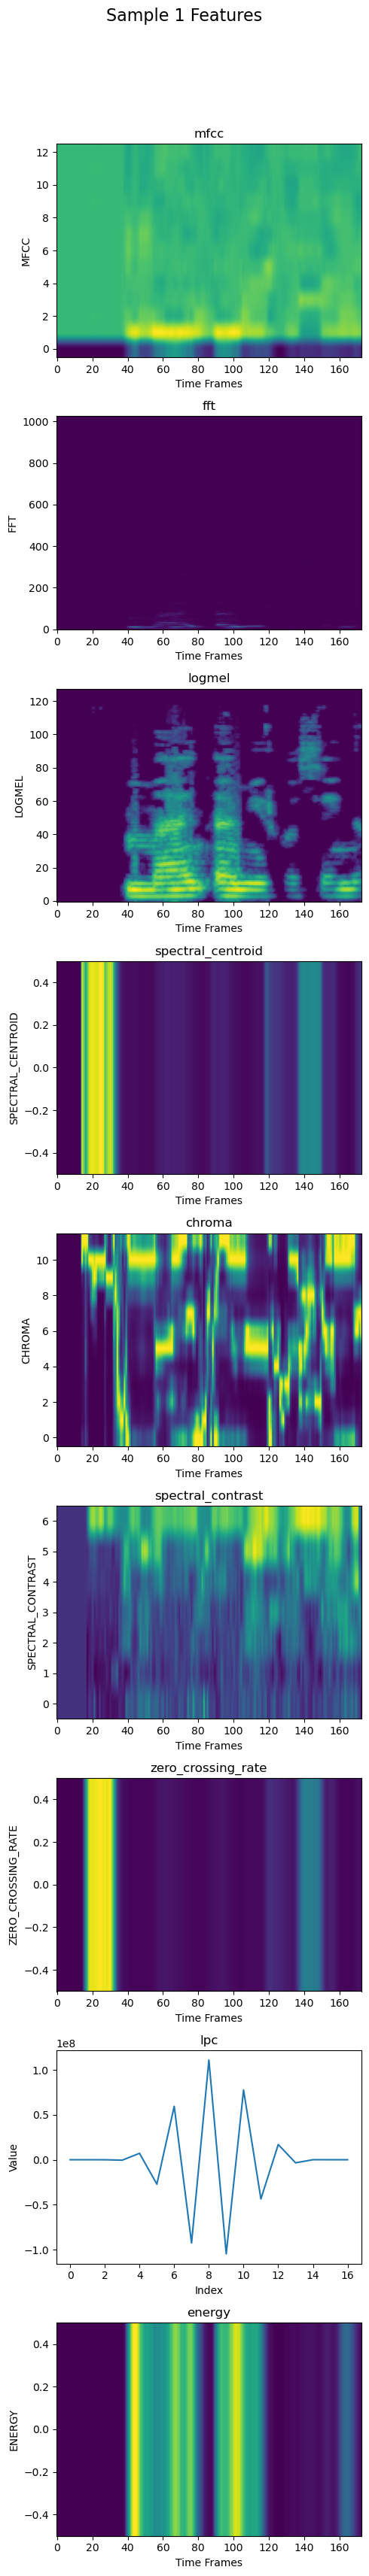

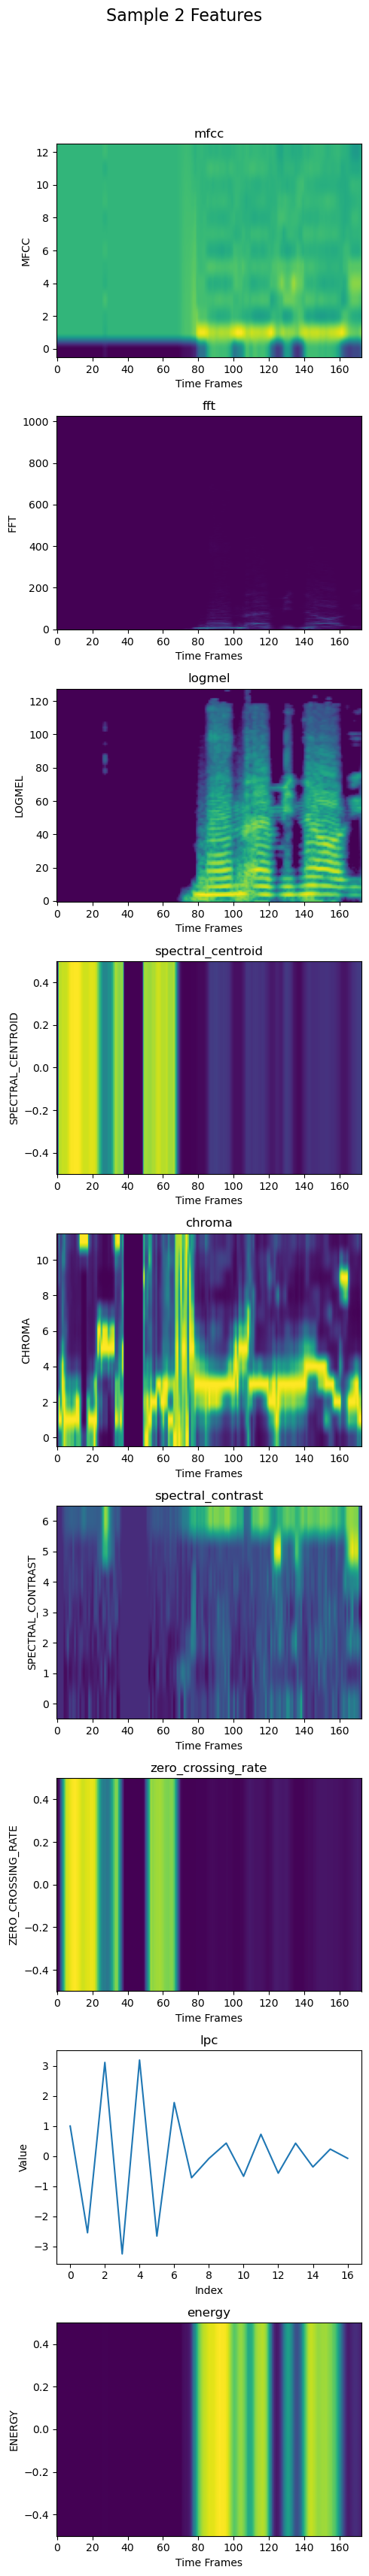

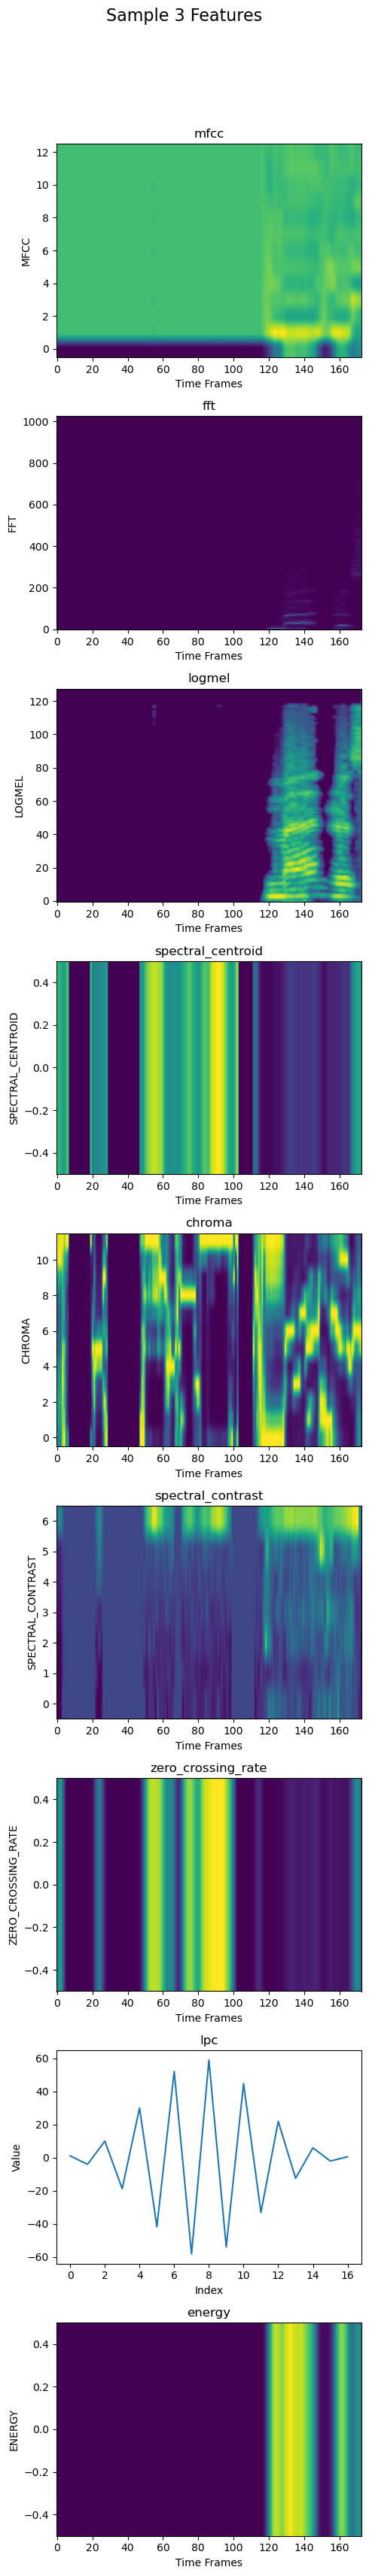

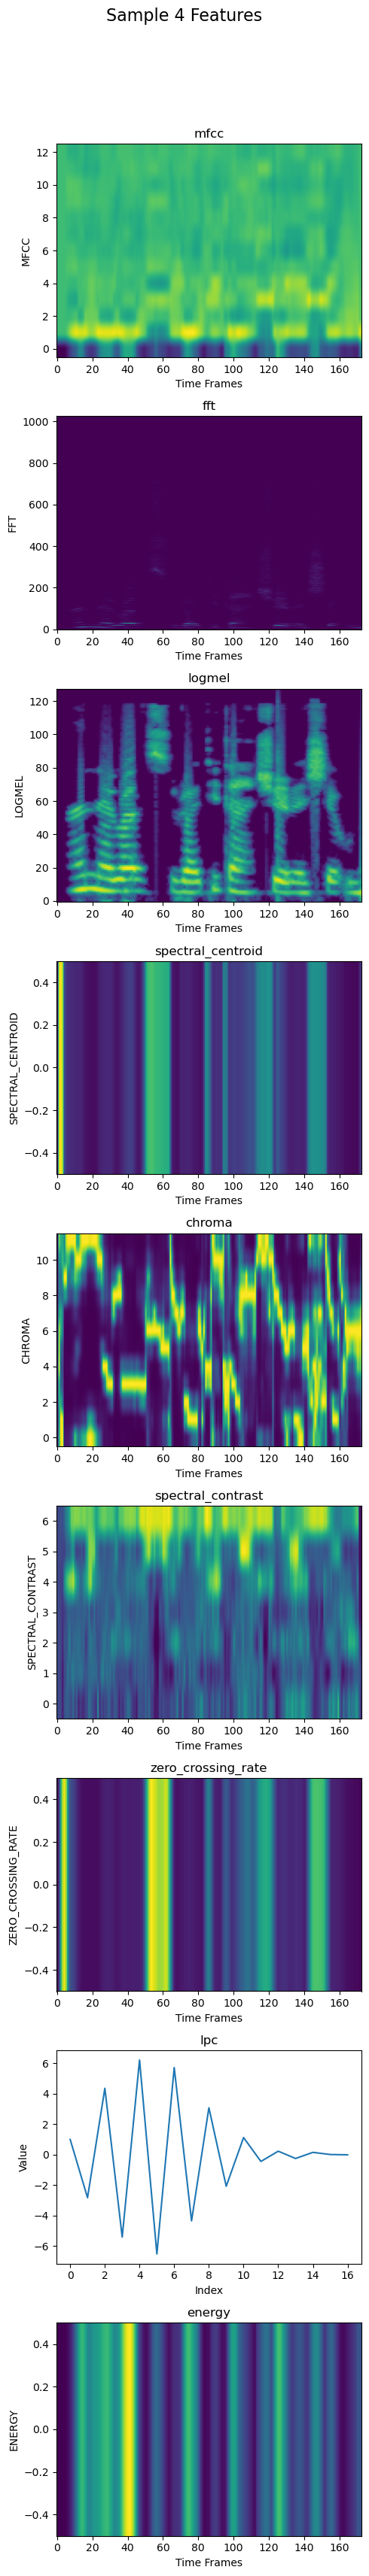

In [58]:
myData.plot_first_five_all_features()

In [59]:
myData.extract_and_save_all_features()


Extracting and saving features for all samples...


100%|██████████| 676/676 [7:34:30<00:00, 40.34s/it]   

Feature extraction and saving complete.


In [ ]:

# ----------------- USAGE EXAMPLE -----------------
if __name__ == "__main__":
    # Define your directories and parameters.
    audio_root = "path/to/your/audio/files"    # Directory containing your .mp3 files
    features_save_dir = "saved_features"       # Directory where segments and features will be saved
    
    # Example 1: Using original audio files and extracting features on the fly.
    dataset = AudioDataset(root_dir=audio_root,
                           task="gender",
                           segment_duration=2.0,
                           segment_overlap=0.5,
                           save_features_dir=features_save_dir,
                           feature_list=['mfcc', 'fft', 'logmel', 'energy', 'spectral_centroid'])
    
    sample = dataset[0]
    print("Sample Metadata (Original):", sample["metadata"])
    if isinstance(sample["features"], list):
        print("Number of segments extracted:", len(sample["features"]))
    
    # Plot all features for the first five samples.
    dataset.plot_first_five_all_features()

    # Example 2: Run batch extraction and saving for all samples.
    dataset.extract_and_save_all_features()

    # Example 3: Later, load using extracted features mode.
    dataset_extracted = AudioDataset(root_dir=audio_root,
                                     task="gender",
                                     save_features_dir=features_save_dir,
                                     use_extracted_features=True)
    
    sample_extracted = dataset_extracted[0]
    print("Sample Metadata (Extracted):", sample_extracted["metadata"])
    print("Loaded extracted features keys:", list(sample_extracted["features"].keys()))


In [5]:
import torch

# Clear GPU memory
torch.cuda.empty_cache()

# To check reserved memory
print(torch.cuda.memory_reserved())

# To check allocated memory
print(torch.cuda.memory_allocated())


0
0


In [36]:
myData = AudioDataset("../../HW1_M", preprocessed_dir="../../preprocessed")

In [ ]:
# myData.preprocess_and_save()

Processing Audio Files: 100%|██████████| 676/676 [06:31<00:00,  1.73it/s]


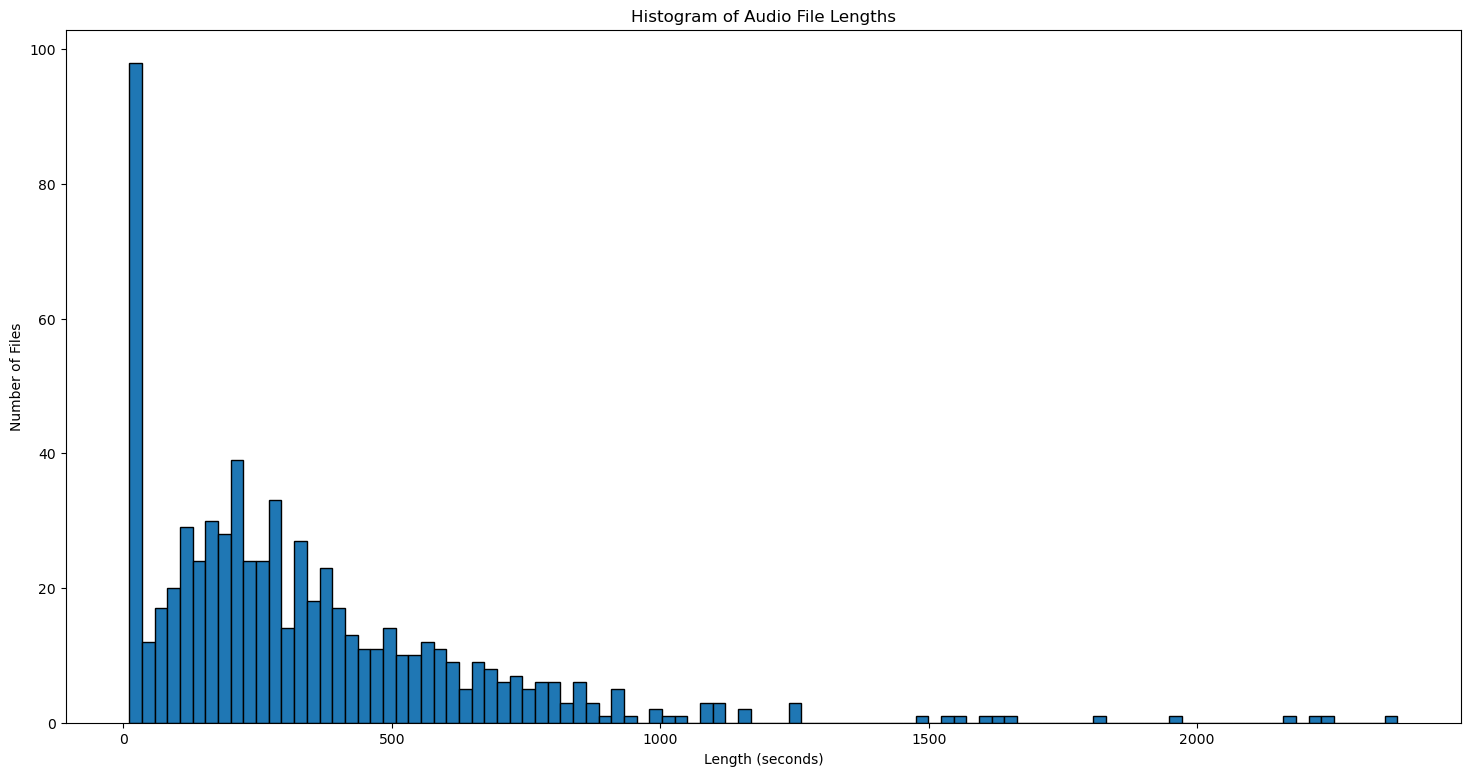

Minimum audio length: 10.87 seconds


In [21]:
myData.plot_audio_lengths()